## Problem 4: Brain food (20 points)

This problem gives you some experience with convolutional neural networks for image classification using [TensorFlow](https://en.wikipedia.org/wiki/TensorFlow).  

The classification task is to discriminate real optical images of brain activity in mice from 
fake images that were constructed using a [generative adversarial network (GAN)](https://en.wikipedia.org/wiki/Generative_adversarial_network).
A paper on the underlying imaging technologies developed by Yale researchers is [here](https://www.nature.com/articles/s41592-020-00984-6).

For this problem we'll walk you through the following steps:
* Downloading the data
* Loading the data
* Displaying some sample images
* Building a classification model using a simple CNN

After this, your task will be to improve upon this baseline model by building, training, and evaluating two more CNNs. 



###  Downloading the data

The data are contained in a group of compressed files on AWS. There are 10 files of real images, 
and 10 files of fake images; each file is roughly 100 MB in size; so the entire dataset is about 2 GB.
You should download the data to the computer you are running on, and place the in a folder named "data".

*Important note:* If you do not have enough space to download all of the data, just download what you can;
there will be no penalty for running on less data. If you want assistance running in Google Colab, please let us know.
You'll need to download segments 7,8,9 (real and fake) for testing, and at least one other segment for training.

Here are URLs to access the 20 data files:


https://sds365.s3.amazonaws.com/calcium/real_0.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_1.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_2.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_3.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_4.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_5.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_6.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_7.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_8.gz <br>
https://sds365.s3.amazonaws.com/calcium/real_9.gz <br>


https://sds365.s3.amazonaws.com/calcium/fake_0.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_1.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_2.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_3.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_4.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_5.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_6.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_7.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_8.gz <br>
https://sds365.s3.amazonaws.com/calcium/fake_9.gz <br>




We import some Python packages from TensorFlow and Keras.

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import gzip
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.4.0'

Some helper functions for reading the data and plotting images.

In [3]:
def plot_images(imgs, title):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs[i], cmap='rainbow')
        plt.axis('off')
    plt.suptitle(title)
    
def read_gz(filedir, shape=[-1,128,128]):
    print('reading %s' % filedir)
    with gzip.open(filedir, 'rb') as f:
        content = f.read()
    imgs = np.frombuffer(content, dtype='float32').reshape(shape)
    return imgs

def load_data(pieces):
    data = []
    label = []
    print('Loading data:\n-------------')
    for i in pieces:
        real_img = read_gz('data/real_{:d}.gz'.format(i), shape=[-1,128,128, 1])
        fake_img = read_gz('data/fake_{:d}.gz'.format(i), shape=[-1,128,128, 1])
        real_label = np.zeros((real_img.shape[0],1))
        fake_label = np.zeros((fake_img.shape[0],1))
        real_label[:,0] = 0
        fake_label[:,0] = 1
        data.append(real_img)
        data.append(fake_img)
        label.append(real_label)
        label.append(fake_label)
    print()
    data_all = np.concatenate(data, axis=0)
    label_all = np.concatenate(label, axis=0)
    return data_all, label_all
    


### Loading the data 

Let's look at some images. 

In [4]:
real_images = read_gz('data/real_0.gz')
fake_images = read_gz('data/fake_0.gz')

# real_img are original data, fake_img are synthetic data generated using a GAN model


reading data/real_0.gz
reading data/fake_0.gz


Each of the images is 128x128 pixels, and there are 2048 images in each file:

In [5]:
real_images.shape, fake_images.shape

((2048, 128, 128), (2048, 128, 128))

### Displaying some sample images

Now we'll display some real and fake images. Can you spot any differences between the two. Do you think that you could learn to tell them apart? Please comment below.

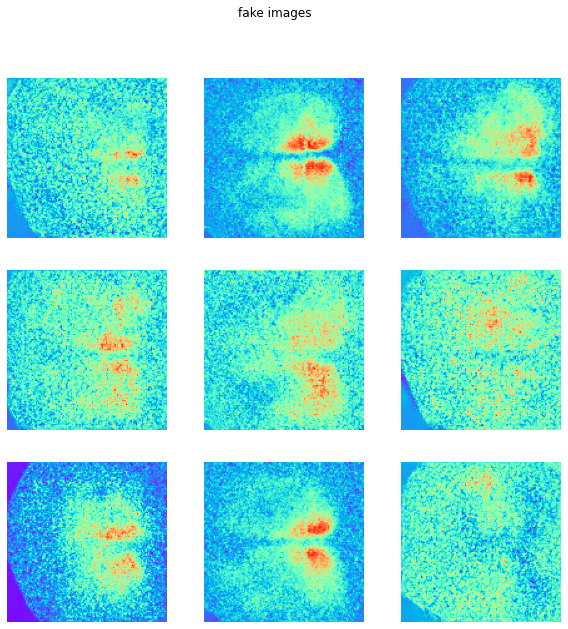

In [6]:
plot_images(real_images, 'real images')
plot_images(fake_images, 'fake images')

[your markdown here]

### 4.1 Building a baseline model

The code below trains and evaluates a baseline model. The model is trained on six of the data files (3 real, and 3 fake, about 12,000 images total) and is tested on six of the data files. 
We begin by loading in the data.


In [7]:
train_images, train_labels = load_data([0,1])
test_images, test_labels = load_data([7,8])

Loading data:
-------------
reading data/real_0.gz
reading data/fake_0.gz
reading data/real_1.gz
reading data/fake_1.gz

Loading data:
-------------
reading data/real_7.gz
reading data/fake_7.gz
reading data/real_8.gz
reading data/fake_8.gz



Next, we initialize our convolutional neural network. This particular network has four layers: A convolutional layer, a max pooling latter, a flattened layer, and a dense layer with two terminal neurons and no activation function. The total number of parameters in this network is 62,338.


In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Flatten())
model.add(layers.Dense(2))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30752)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 61506     
Total params: 62,338
Trainable params: 62,338
Non-trainable params: 0
_________________________________________________________________


Next, we train the model. Here we just train for two "epochs", where each epoch scans through the 
data in random order, processing a batch of images in each stochastic gradient descent step.


In [9]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=2, validation_split=0.2, shuffle=True)

Epoch 1/2
205/205 [==============================] - 21s 101ms/step - loss: 0.4774 - accuracy: 0.7642 - val_loss: 0.0258 - val_accuracy: 0.9976
Epoch 2/2
205/205 [==============================] - 20s 99ms/step - loss: 0.0436 - accuracy: 0.9958 - val_loss: 0.0129 - val_accuracy: 1.0000


Finally, we evaluate the model on the test data (the last three segments of images: 7,8,9). Your accuracy may vary for this identical configuration due to the randomness in SGD.

In [10]:
est_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('test accuracy: {:.4f}'.format(test_acc))

256/256 - 6s - loss: 0.2870 - accuracy: 0.8322
test accuracy: 0.8322


In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((4,4)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 124, 124, 32)      832       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 32)        4128      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               200832    
_________________________________________________________________
dense_18 (Dense)             (None, 2)               

In [26]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=2, validation_split=0.2, shuffle=True)

Epoch 1/2
205/205 [==============================] - 27s 131ms/step - loss: 0.5365 - accuracy: 0.7165 - val_loss: 1.0661 - val_accuracy: 0.5692
Epoch 2/2
205/205 [==============================] - 27s 130ms/step - loss: 0.1914 - accuracy: 0.9296 - val_loss: 0.0907 - val_accuracy: 0.9677


In [27]:
est_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('test accuracy: {:.4f}'.format(test_acc))

256/256 - 5s - loss: 1.0541 - accuracy: 0.8104
test accuracy: 0.8104


### 4.2 and 4.3: Improving upon the baseline

Your job is to improve upon this baseline model. _You should always test on the same segments 7,8,9 as above._ You can extend this model in various ways:

* Train on more data (but always test on the same test set)
* Add more convolutional layers 
* Add more dense layers, using an activation function
* Regularize using a dropout layer
* Use a different mini-batch size

For each model that you decide to train, describe how and why you built this model. For example, you can:

* Give a diagram showing the sequence of layers used;
* Explain your rationale for using each of the layers;
* Comment on the number of parameters used by the model, and which layers have the most parameters;
* Describe your findings on number of epochs and training data size;
* Comment on models you experimented with but did not include;
* Describe the increase or decrease in accuracy that resulted.

When we evaluate your notebook, we will look for (1) significant improvements in test accuracy (2) descriptions of your models that show understanding of how they work and (3) why you chose a given architecture.
